Intensity vs Fermi Chopper frequency -- Chopper 2

Just try the original parameters

In [1]:
cd ~/dv/sns-chops/resolution/ARCS/PyChop/

/SNS/users/lj7/dv/sns-chops/resolution/ARCS/PyChop


In [2]:
import numpy as np, os, sys, glob
from matplotlib import pyplot as plt

In [3]:
from mcni.utils import conversion as C

In [4]:
%matplotlib notebook

# Exp data

In [5]:
import Vdata2018
reload(Vdata2018)

<module 'Vdata2018' from 'Vdata2018.pyc'>

In [6]:
# expdata = Vdata2018.ExpData(os.path.join(Vdata2018.datadir, './V_Cali_Int_Res_FC1_2018.dat'))
expdata = Vdata2018.ExpData(os.path.join(Vdata2018.datadir, './V_Cali_Int_Res_FC2_2018_v2.dat'))

reading data. please wait...
  done


In [7]:
monitor_int_data = np.loadtxt('../V_Cali_MonitorInt_FC2_2018_v2.dat')
runno2monitorint = dict()
for runno, mint, vscatt, duration in monitor_int_data:
    runno2monitorint[int(runno)] = mint/duration

In [8]:
unique_nominal_Eis = set( list(expdata.Ei_list)) 

In [9]:
# unique_nominal_Eis

# Load mcvine sims

In [10]:
mcvine_table = np.loadtxt('../mcvine-FWHM-counts.dat')

In [11]:
mcvine_Eis, mcvine_freqs, mcvine_FWHMs, mcvine_counts = mcvine_table.T

In [12]:
Ei = 100.

In [13]:
condition = np.isclose(expdata.vdata.Energy, Ei)

In [14]:
expdata.vdata.RunNumber[condition]

13     108045.0
28     108064.0
61     108101.0
74     108114.0
96     108138.0
109    108151.0
127    108169.0
142    108184.0
172    108007.0
181    108026.0
Name: RunNumber, dtype: float64

In [15]:
expdata.chopper_freqs[condition]

array([180., 240., 300., 360., 420., 480., 540., 600.,  60., 120.])

In [16]:
mint = np.array([runno2monitorint[rn] for rn in expdata.vdata.RunNumber[condition]])

In [17]:
mcvine_conditions = np.isclose(mcvine_Eis, Ei)

In [18]:
scale_vscatt2mcvine = 1.1e6
scale_monitor2mcvine = 3

PyChop

In [19]:
sys.path.insert(0, "/SNS/users/lj7/dv")

In [20]:
from PyChop import PyChop2

In [21]:
instrument = PyChop2('arcs-opt.yaml', 'ARCS-100-1.5-SMI', 600)

In [22]:
instrument.getResFlux(Etrans=0, Ei_in=100., frequency=600)

(array([4.11798862]), array([45.88395835]))

In [23]:
def flux_res_list_pychop(
    fc_freq_list,
    E=0,
    aperture_width=0.1751, S1=281., S2=79., B1=0.087, B2=0.4, Emod=172., 
    Ei = 100.,
    fc_pslit = 1.5, fc_pslat = 0.41, fc_radius=50., fc_rho = 580.,
    fc_choice='ARCS-100-1.5-SMI'):
    
    template = open('./arcs-opt-template.yaml').read()
    content = template.format(aperture_width=aperture_width)
    optyaml = 'arcs-opt.yaml'
    with open(optyaml, 'wt') as of:
        of.write(content)
    instrument = PyChop2(optyaml, fc_choice)
    instrument.ei = Ei
    instrument.moderator.mod_pars = [S1, S2, B1, B2, Emod]
    # print instrument.moderator.mod_pars
    # Fermi chopper
    fc = instrument.chopper_system.packages[fc_choice]
    fc.pslit = fc_pslit
    fc.pslat = fc_pslat
    fc.radius = fc_radius
    fc.rho = fc_rho
    # 
    ret = []
    for freq in fc_freq_list:
        res, flux = instrument.getResFlux(Etrans=E, Ei_in=Ei, frequency=freq)
        res = res[0]; flux = flux[0]
        ret.append( (flux*res, res) )
    return np.array(ret)

1.8angstrom corresponds to ? meV

In [24]:
v_1p8AA = C.k2v(2*np.pi/1.8)

In [25]:
def getExpXY(Ei):
    "return freq, monitor intensity, V scatt intensity, FWHM"
    condition = np.isclose(expdata.vdata.Energy, Ei)
    x = expdata.chopper_freqs[condition]
    y1 = np.array([runno2monitorint[rn] for rn in expdata.vdata.RunNumber[condition]]) *C.e2v(Ei)/v_1p8AA
    y2 = expdata.intensity[condition]  # this is integrated S(E) intensity
    y3 = expdata.FWHM[condition]
    return x,y1,y2,y3

In [26]:
def getMcvineXY(Ei):
    "return freq, counts, FWHM"
    mcvine_conditions = np.isclose(mcvine_Eis, Ei)
    freqs = mcvine_freqs[mcvine_conditions]
    counts = mcvine_counts[mcvine_conditions]
    FWHMs = mcvine_FWHMs[mcvine_conditions]
    return freqs, counts, FWHMs

# All energies

In [27]:
unique_nominal_Eis

{8.0,
 10.0,
 12.0,
 15.0,
 20.0,
 25.0,
 30.0,
 40.0,
 50.0,
 60.0,
 70.0,
 80.0,
 90.0,
 100.0,
 125.0,
 150.0,
 200.0,
 250.0,
 300.0,
 400.0,
 500.0,
 600.0}

In [28]:
Ei_list = sorted(unique_nominal_Eis)
datatable = dict()
import warnings
for Ei in Ei_list:
    freqs, monInt, vscattInt, expFWHM = getExpXY(Ei)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model_flux, model_res = flux_res_list_pychop(freqs, Ei=Ei, fc_rho=640., fc_pslit=1.5, fc_pslat=0.35).T
    mcv_freqs, mcv_Int, mcv_FWHM = getMcvineXY(Ei)
    datatable[Ei] = freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM

In [29]:
def calc_deteff(He_press = 10., He_T = 300., width = 0.0254*.8, E=100):
    "He_press: atm; He_T: K; width: meter; E: meV"
    pressure = He_press * 101325
    mu = 5333.0e-28/1.798 * np.sqrt(81.81/E) * pressure/He_T * 300*2.414e20
    l = 1./mu
    return 1-np.exp(-width/l)

In [30]:
calc_deteff(He_press = 10., He_T = 300., width = 0.0254*.8, E=100)

0.7364222339203336

# Publication

In [31]:
Ei_list2 = np.array(Ei_list)[:-1]
Ei_list2.shape = -1,3
Ei_list2a = Ei_list2[:, 1] 
Ei_list2a

array([ 10.,  20.,  40.,  70., 100., 200., 400.])

In [32]:
Ei_list2

array([[  8.,  10.,  12.],
       [ 15.,  20.,  25.],
       [ 30.,  40.,  50.],
       [ 60.,  70.,  80.],
       [ 90., 100., 125.],
       [150., 200., 250.],
       [300., 400., 500.]])

In [33]:
# Ei_list2a = [10., 20., 40., 70., 150., 300., 500.]
Ei_list2a = [10, 30, 60, 100, 200, 400.]

In [34]:
mcvine_scale = 1./25 * 1.4/2.
pychop_scale = 1e-3 * 1e6 /25 * 1.4/2
mon_scale = 1e5 / 25 /60.
# mon_scale *= 2  # fudge factor
vscatt_scale = 2.5e4

mcvine_scale/=2
pychop_scale/=2
vscatt_scale/=2

<IPython.core.display.Javascript object>


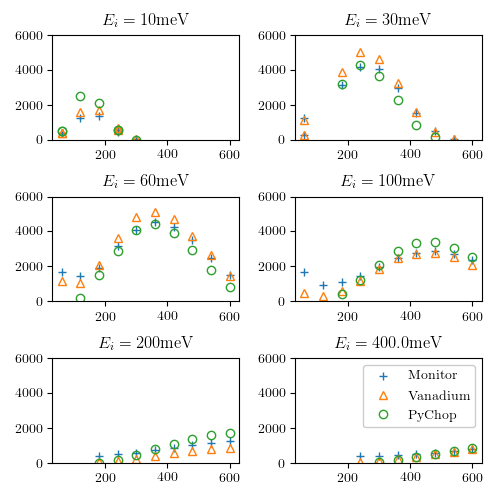

In [35]:
N = len(Ei_list2a)
cols = 2
rows = (N-1)//cols + 1
# rows = N//cols + 1
plt.figure(figsize=(5,5))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for i, Ei in enumerate(Ei_list2a):
    freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM = datatable[Ei]
    # vscattInt = vscattInt / calc_deteff(He_press = 10., He_T = 300., width = 0.0254*.8, E=Ei)
    plt.subplot(rows, cols, i+1)
    plt.title(r'$E_i=%s$meV' % Ei)
    # plt.plot(mcv_freqs, mcv_Int*mcvine_scale, 'v', mfc='none', label='mcvine')
    plt.plot(freqs, monInt*mon_scale, '+', label='Monitor')
    plt.plot(freqs, vscattInt*vscatt_scale, '^', mfc='none', label='Vanadium')
    plt.plot(freqs, model_flux*pychop_scale, 'o', mfc='none', label='PyChop')
    plt.xlim(30, 630.)
    plt.ylim(0, 6000)
    if i==N-1: plt.legend(framealpha=1)

#plt.subplot(rows, cols, N+1)
#plt.axis('off')
# plt.plot([0], [0], 'v', mfc='none', label='MCViNE')
#plt.plot([0], [10], '+', label='monitor')
#plt.plot([0], [10], '^', mfc='none', label='Vanadium')
#plt.plot([0], [10], 'o', mfc='none', label='PyChop')
plt.tight_layout()

<IPython.core.display.Javascript object>


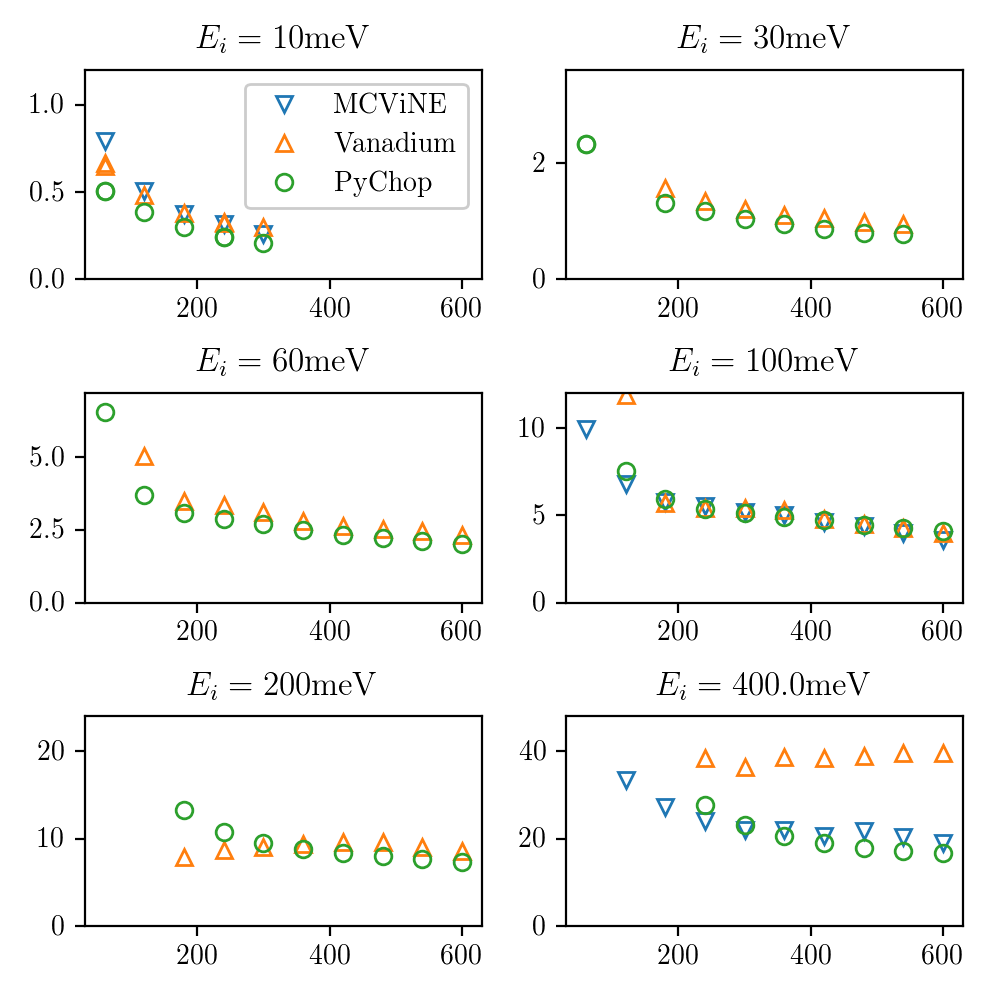

In [42]:
N = len(Ei_list2a)
cols = 2
rows = (N-1)//cols + 1
# rows = N//cols + 1
plt.figure(figsize=(5,5))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for i, Ei in enumerate(Ei_list2a):
    freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM = datatable[Ei]
    plt.subplot(rows, cols, i+1)
    plt.title('$E_i=%s$meV' % Ei)
    plt.plot(mcv_freqs, mcv_FWHM, 'v', mfc='none', label='MCViNE')
    plt.plot(freqs, expFWHM, '^', mfc='none', label='Vanadium')
    plt.plot(freqs, model_res, 'o', mfc='none', label='PyChop')
    plt.xlim(30, 630.)
    plt.ylim(0, Ei*.12)
    if i==0: plt.legend(framealpha=1)
# plt.subplot(rows, cols, N+1)
# plt.axis('off')
# plt.plot([0], [0], 'v', mfc='none', label='MCViNE')
# plt.plot([0], [0], '^', mfc='none', label='Vanadium')
# plt.plot([0], [0], 'o', mfc='none', label='PyChop')
plt.tight_layout()

In [36]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [37]:
mcvine_scale = 1./25 * 1.4/2. 
pychop_scale = 1e-3 * 1e6 /25 * 1.4/2
mon_scale = 1e5 / 25 /60.
# mon_scale *= 2  # fudge factor
vscatt_scale = 2.5e4

mcvine_scale*=60./1.4
pychop_scale*=60./1.4
mon_scale*=60./1.4
vscatt_scale*=60./1.4

mcvine_scale/=2
pychop_scale/=2
vscatt_scale/=2

<IPython.core.display.Javascript object>


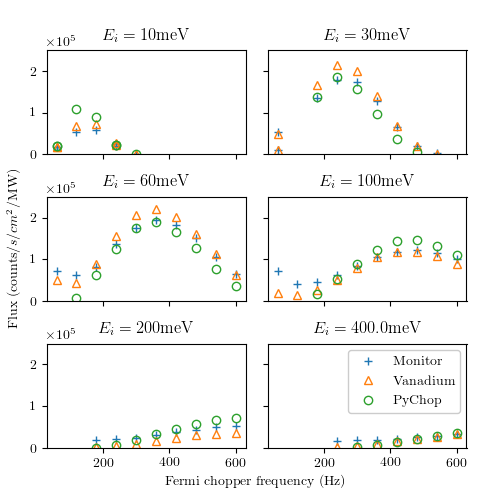

In [39]:
N = len(Ei_list2a)
cols = 2
rows = (N-1)//cols + 1
# rows = N//cols + 1
fig, ax = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True, figsize=(5,5))

i = 0
for row in ax:
    for cell in row:
        Ei = Ei_list2a[i]
        freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM = datatable[Ei]
        # vscattInt = vscattInt / calc_deteff(He_press = 10., He_T = 300., width = 0.0254*.8, E=Ei)
        cell.set_title(r'$E_i=%s$meV' % Ei)
        # plt.plot(mcv_freqs, mcv_Int*mcvine_scale, 'v', mfc='none', label='mcvine')
        cell.plot(freqs, monInt*mon_scale, '+', label='Monitor')
        cell.plot(freqs, vscattInt*vscatt_scale, '^', mfc='none', label='Vanadium')
        cell.plot(freqs, model_flux*pychop_scale, 'o', mfc='none', label='PyChop')
        cell.set_xlim(30, 630.)
        cell.set_ylim(0, 250000)
        cell.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        if i==N-1: cell.legend(framealpha=1)
        i+=1

#plt.subplot(rows, cols, N+1)
#plt.axis('off')
# plt.plot([0], [0], 'v', mfc='none', label='MCViNE')
#plt.plot([0], [10], '+', label='monitor')
#plt.plot([0], [10], '^', mfc='none', label='Vanadium')
#plt.plot([0], [10], 'o', mfc='none', label='PyChop')
fig.text(0.33, 0.03, 'Fermi chopper frequency (Hz)')
fig.text(0.01, 0.64, 'Flux (counts/$s/cm^2$/MW)', rotation='vertical')
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
plt.savefig("/SNS/users/lj7/tmp/Fig4.eps")

<IPython.core.display.Javascript object>


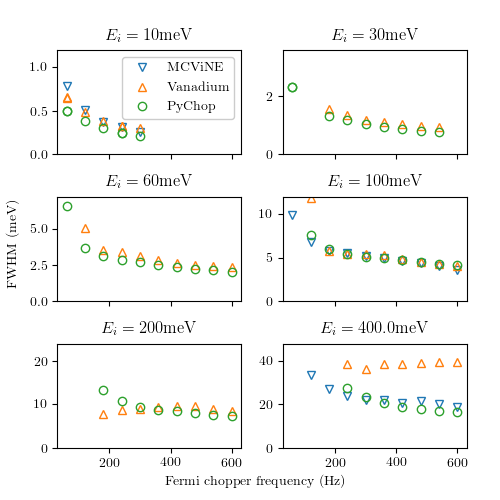

In [40]:
N = len(Ei_list2a)
cols = 2
rows = (N-1)//cols + 1
# rows = N//cols + 1

fig, ax = plt.subplots(nrows=rows, ncols=cols, sharex=True, figsize=(5,5))

i = 0
for row in ax:
    for cell in row:
        Ei = Ei_list2a[i]
        freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM = datatable[Ei]
        cell.set_title('$E_i=%s$meV' % Ei)
        cell.plot(mcv_freqs, mcv_FWHM, 'v', mfc='none', label='MCViNE')
        cell.plot(freqs, expFWHM, '^', mfc='none', label='Vanadium')
        cell.plot(freqs, model_res, 'o', mfc='none', label='PyChop')
        cell.set_xlim(30, 630.)
        cell.set_ylim(0, Ei*.12)
        if i==0: cell.legend(framealpha=1)
        i+=1

fig.text(0.33, 0.03, 'Fermi chopper frequency (Hz)')
fig.text(0.01, 0.58, 'FWHM (meV)', rotation='vertical')
fig.tight_layout(rect=[0.03, 0.03, .97, 0.97])
plt.savefig("/SNS/users/lj7/tmp/Fig5.eps")